# Training:

This project uses a machine learning model of classification and segmentation. It is based on a U-Net architecture, which uses a set of images and binary masks to train. 

### Build images and masks

The set of images and binary masks used for training can be generated via **satproc_extract_chips**.  
This tool uses an image (or a set of images) and a vectorial file to create another set of images of a specific size and their masks.
In addition, several features can be included like the rescale option to bring the output with pixel values between 0 to 255. All of them are fully explained below. 

The vector file contains many categories of objects, then the mask will have a binary band for each of them. 


![chips](img/mask_ej.png)

In [ ]:
!ls data/shp/gt/

In [ ]:
!satproc_extract_chips     \
    ./data/dif_NBR_img/dif_nbr.tif \
    -o ./data/data_train/300_150/ \
    --size 300 \
    --step-size 150 \
    --aoi ./data/shp/gt/burn-area.geojson \
    --labels ./data/shp/gt/burn-area.geojson \
    --label-property 'class' \
    --classes 'fire' \
    --rescale \
    --rescale-mode percentiles \
    --upper-cut 98 --lower-cut 2



In [ ]:
#!ls ./data/data_train/300_150/

###### The options:

* **the argument** the path to the source image or a folder with contains a set of images

* **o** path to destiny images and masks
* **size**size of the generated images and masks 
* **step-size** the size of the step in the slide windows process. if the step size is smaller than the size then an overlap is generated. This could be useful to increase the amount of training data.
* **crs** it set an epsg in case the images don't have it. 
* **label-property** the name of the field in the shapefile where each category is defined. 
* **classes** name of the different categories (all split by a space)
* **aoi** path to the shapefile that delimits the region of interest. It can be the same that the shapefile with the categories or other.
* **rescale** to rescale the images to a range 1-255
* **rescale-mode** Rescaled mode:  percentiles, custom_rgb, values. 

Percentiles mode will rescale each band if the image to a scale defined by the percentiles considering the upper and lower cuts. For example --upper-cut 98 --lower-cut 2

The custom_rgb will rescale the 3 first bands from 0 to 0.3 and the rest of them considering the percentiles.

The values mode will rescale all the bands in the image considering the min and max values defined. For example --Min 0 --Max 0.3   


## Trainig  

First, we should import the libraries needed 

In [1]:
from fire.unet.train import TrainConfig, train
from fire.unet.evaluate import plot_data_generator
import os

/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/

To set the parameters of the training process


In [6]:
train_config = TrainConfig(width=320,  #  size of the image (160, 320,etc)
                     height=320,
                     n_channels=1,  #  number of channels of the image rgb -> 3
                     n_classes=1, # number of classes to clasify
                     apply_image_augmentation=True, #  increase the amount of training data with a image augmentation process
                     seed=42,
                     epochs=15, 
                     batch_size=16, 
                     steps_per_epoch=150, 
                     early_stopping_patience=3, 
                     validation_split=0.2, 
                     images_path=os.path.join('./data/data_train', '300_100'), #ruta a las imágenes
                     model_path=os.path.join('./data/weights/', 'UNet_fire_1Dim_300_100_spe150.h5'),#  ruta al archivo de entrenamiento
                     evaluate=False,
                     weights = [0.5]) 

To plot some exaples of images and masks

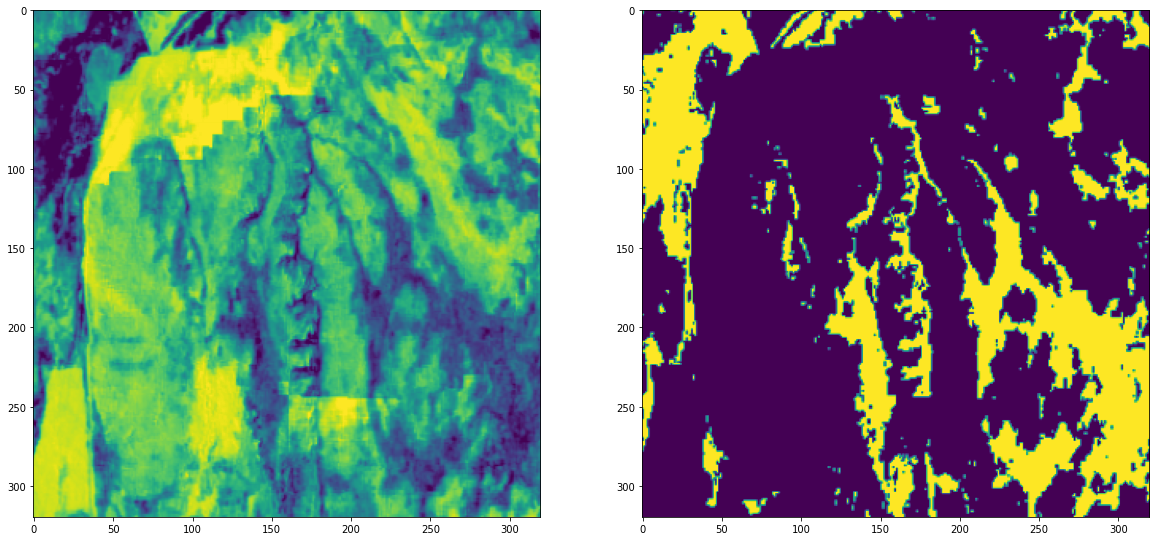

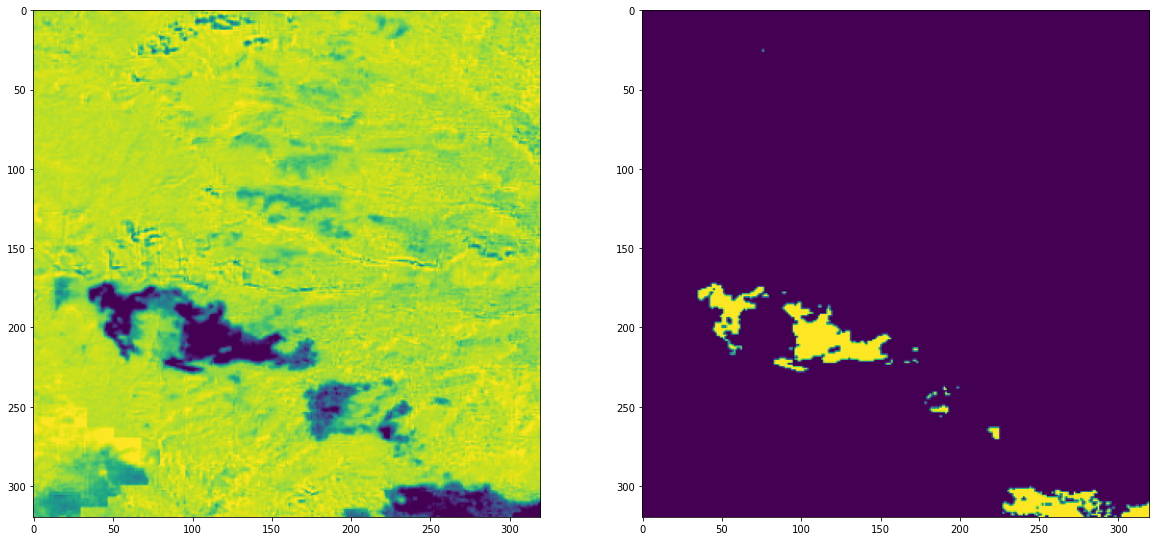

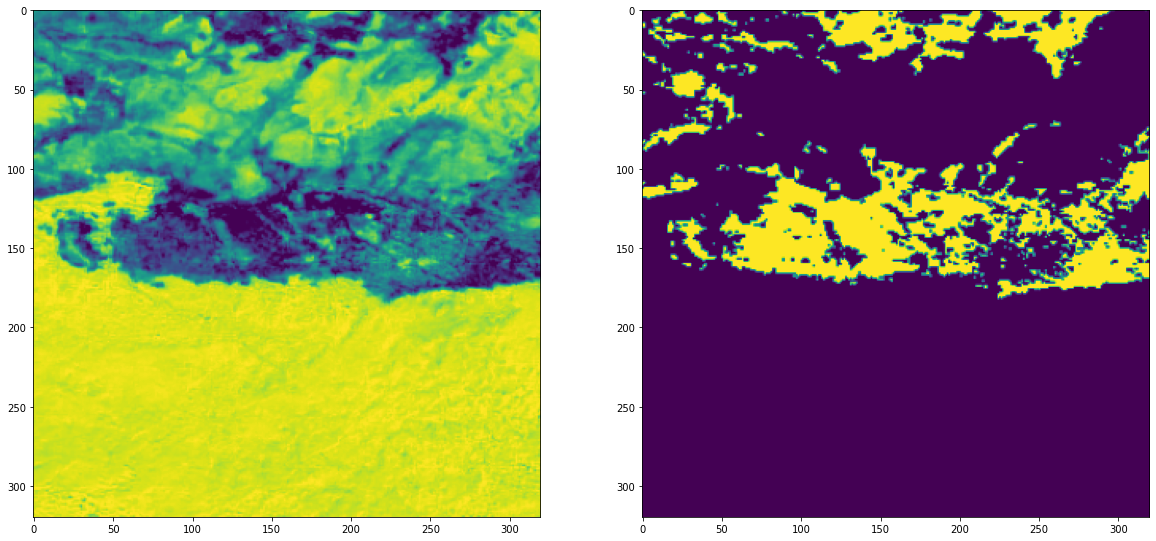

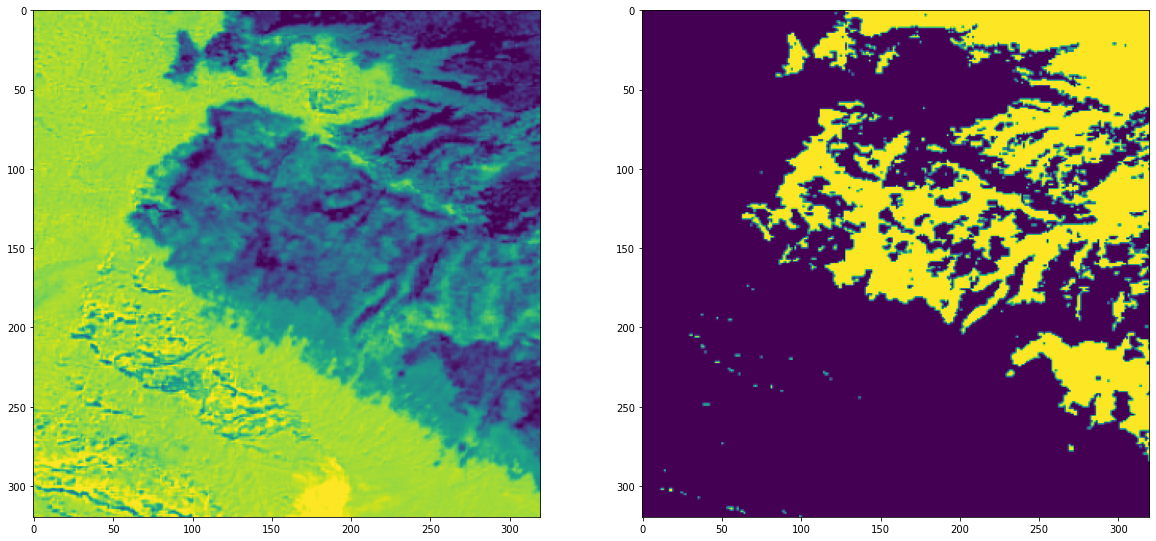

In [3]:

plot_data_generator(train_config=train_config, num_samples=4, fig_size=(20,10))

To train

In [7]:
res_config = train(train_config)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 320, 320, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

Epoch 1/15
150/150 [==============================] - 57s 380ms/step - loss: 0.1310 - accuracy: 0.8886 - iou: 0.4202 - mean_iou: 0.6381 - val_loss: 0.0969 - val_accuracy: 0.9013 - val_iou: 0.4998 - val_mean_iou: 0.7147

Epoch 00001: val_loss improved from inf to 0.09690, saving model to ./data/weights/UNet_fire_1Dim_300_100_spe150.h5
Epoch 2/15
150/150 [==============================] - 52s 348ms/step - loss: 0.0728 - accuracy: 0.9117 - iou: 0.4455 - mean_iou: 0.7297 - val_loss: 0.0599 - val_accuracy: 0.9004 - val_iou: 0.5090 - val_mean_iou: 0.7420

Epoch 00002: val_loss improved from 0.09690 to 0.05993, saving model to ./data/weights/UNet_fire_1Dim_300_100_spe150.h5
Epoch 3/15
150/150 [==============================] - 52s 349ms/step - loss: 0.0718 - accuracy: 0.9124 - iou: 0.4652 - mean_iou: 0.7488 - val_loss: 0.0636 - val_accuracy: 0.9151 - val_iou: 0.5290 - val_mean_iou: 0.7559

Epoch 00003: val_loss did not improve from 0.05993
Epoch 4/15
150/150 [==============================] -

Print some metrics

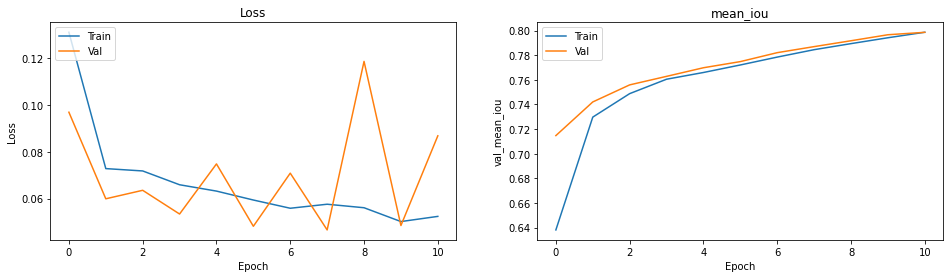

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_iou'])
plt.plot(res_config.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()